In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
path = '/home/daiict/CVShare/Jeni/hts/bioassay-datasets/'
p_fingerprints = []
labels = []
with open(path+'AID362red_train.csv') as csvfile:
    readcsv = csv.reader(csvfile)
    for row in readcsv:
        p_fingerprints.append(row[:112])
        labels.append(row[-1])

In [3]:
p_fingerprints = np.asarray(p_fingerprints)[1:]
p_fingerprints = p_fingerprints.astype(int)
#p2_fingerprints = np.ones(p_fingerprints.shape)
(no_examples , ip_dim) = p_fingerprints.shape
labels = labels[1:]
print(no_examples,ip_dim)
print("total no of 1s",np.sum(p_fingerprints))
print("total no of 0s",no_examples*ip_dim-np.sum(p_fingerprints))

(3423, 112)
('total no of 1s', 25982)
('total no of 0s', 357394)


In [4]:
p_fingerprints[(p_fingerprints==0)] = -1

In [5]:
labels2 = np.zeros((len(labels),1))
for i,l in enumerate(labels):
    if l=='Active':
        labels2[i] = 1
    else:
        labels2[i] = 0

In [6]:
no_active_ele = (sum(labels2))
print(no_active_ele)

[ 48.]


In [7]:
X_dim = ip_dim
h1_dim = 300
h2_dim = 200
h3_dim = 200
z_dim = 3

In [8]:
def get_train_batch(batch_size):
    samples = np.random.randint(low=0,high=no_examples,size=(batch_size,1))
    train_batch = p_fingerprints[samples].reshape(batch_size,ip_dim)
    train_batch = train_batch.astype(int)
    train_batch = torch.cuda.FloatTensor(train_batch)
    train_batch = Variable(train_batch,requires_grad=False).cuda()
    target = Variable(torch.cuda.FloatTensor(labels2[samples]),requires_grad=False)
    
    return train_batch,target

In [9]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        self.l1 = nn.Linear(X_dim,h1_dim)
        self.l2 = nn.Linear(h1_dim,h2_dim)
        self.l3 = nn.Linear(h2_dim,h3_dim)
        self.l4 = nn.Linear(h3_dim,z_dim)
        
    def forward(self,x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        
        return x

In [10]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder,self).__init__()
        self.l1 = nn.Linear(z_dim,h3_dim)
        self.l2 = nn.Linear(h3_dim,h2_dim)
        self.l3 = nn.Linear(h2_dim,h1_dim)
        self.l4 = nn.Linear(h1_dim,X_dim)
        
    def forward(self,x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.tanh(self.l4(x))
        
        return x

In [11]:
class disc(nn.Module):
    def __init__(self):
        super(disc,self).__init__()
        self.lin1 = nn.Linear(z_dim+2,100)
        self.lin2 = nn.Linear(100,50)
        self.lin3 = nn.Linear(50,30)
        self.lin4 = nn.Linear(30,1)
        
    def forward(self,x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = F.relu(self.lin3(x))
        x = F.sigmoid(self.lin4(x))
        
        return x

In [12]:
def add_label_info(y,batch_size):

    tmp = np.zeros((batch_size,2))
    tmp2 = np.zeros((batch_size,1))
    y = y.cpu().data.numpy().reshape(batch_size,1)
    tmp2[y==0] = 1
    tmp3 = np.zeros((batch_size,1))
    tmp3[y==1] = 1
    tmp = np.concatenate((tmp2,tmp3),1)
    label_info = torch.from_numpy((tmp)).cuda()
    return label_info

In [13]:
def train_model(Q,Q_solver,P,P_solver,D,D_solver,batch_size):
    
    for it in range(800):
        x,y = get_train_batch(batch_size)
        z = Q(x)

        #Reconstruction
        
        x_recon = P(z)
        '''
        x_recon[x_recon<0] = 0
        x_recon[x_recon>0] = 1
        x_tar = Variable(torch.cuda.FloatTensor(x.size()),requires_grad=False)
        x_tar[x==-1] = 0
        x_tar[x==1] = 1'''
        
        criterion = nn.MSELoss()
        CEL = criterion(x_recon, x)
        
        CEL.backward()
        Q_solver.step()
        P_solver.step()
        
        Q.zero_grad()
        P.zero_grad()
        
        #Discriminator
        
        label_info = (add_label_info(y,batch_size))
        z_false = np.concatenate((z.cpu().data.numpy(),label_info.cpu().numpy()),1)
        z_false = Variable(torch.FloatTensor(z_false).cuda())
        #z_false = torch.cat((z,label_info),1)
        z_true = np.random.rand(batch_size,z_dim)
        z_true = np.concatenate((z_true,label_info.cpu().numpy()),1)
        z_true = Variable(torch.FloatTensor(z_true).cuda())
        #z_true = torch.cat((z_true,label_info),1)
        z_true_op = D(z_true)
        
        z_false_op = D(z_false)
        add_small = 1e-20
        #criterion = nn.BCELoss()
        #loss_d = criterion(z_false_op,z_true_op)
        loss_d = -torch.mean(torch.log(z_true_op + add_small) + torch.log(1 - z_false_op + add_small))
        loss_d.backward(retain_variables = True)
        D_solver.step()
        D.zero_grad()
        
        #Updating the encoder
        
        G_loss = -torch.mean(torch.log(z_false_op+1e-20))
        G_loss.backward()
        Q_solver.step()
        Q_solver.zero_grad()
        
        
        
        
        if(it%50==0):
            #print(extra_loss.data[0],CEL.data[0])
            print(CEL.data[0],loss_d.data[0],G_loss.data[0])
            #print(x_recon[0][:50].cpu().data.numpy().T)
            #print()
            #print(x[0][:50].cpu().data.numpy().T)
           # print()
    return Q,P

In [14]:
def generate_model():
    Q = encoder()
    Q.cuda()
    Q_solver = optim.Adam(Q.parameters(),lr=1e-4)
    E_solver = optim.Adam(Q.parameters(),lr = 1e-5)
    P = decoder()
    P.cuda()
    P_solver = optim.Adam(P.parameters(),lr = 1e-4)
    D = disc()
    D.cuda()
    D_solver = optim.Adam(D.parameters(),lr = 1e-4)
    batch_size = 120
    Q,P = train_model(Q,Q_solver,P,P_solver,D,D_solver,batch_size)
    
    return Q,P

In [15]:
Q,P = generate_model()

(1.0139586925506592, 1.3843058347702026, 0.7179368138313293)
(0.25346967577934265, 1.5727452039718628, 0.5211462378501892)
(0.21525579690933228, 1.3864656686782837, 0.65203857421875)
(0.20365355908870697, 1.3447513580322266, 0.6508666276931763)
(0.20269189774990082, 1.270607590675354, 0.6531819701194763)
(0.21294395625591278, 1.1693933010101318, 0.6584470868110657)
(0.1954030692577362, 1.0664788484573364, 0.6590108871459961)
(0.18534249067306519, 0.9515231847763062, 0.6736583709716797)
(0.1612895131111145, 0.8886004686355591, 0.6658092737197876)
(0.14007630944252014, 0.8556796312332153, 0.6693929433822632)
(0.13658259809017181, 0.843866765499115, 0.6739875674247742)
(0.1446865200996399, 0.7962548732757568, 0.6868253946304321)
(0.15264640748500824, 0.7566505670547485, 0.6909030079841614)
(0.14199908077716827, 0.744472086429596, 0.6891518235206604)
(0.12887729704380035, 0.7230116128921509, 0.6956620812416077)
(0.11026468127965927, 0.7169535756111145, 0.6935684084892273)


In [20]:
entire_batch,batch_labels = get_train_batch(no_examples)
z_encoded = Q(entire_batch)
batch_labels_np = batch_labels.cpu().data.numpy()

x_encoded = z_encoded.cpu().data.numpy()[:,0]
y_encoded = z_encoded.cpu().data.numpy()[:,1]
z_encoded = z_encoded.cpu().data.numpy()[:,2]

In [21]:
batch_labels_np = batch_labels_np.astype(int)
print(batch_labels_np.dtype)
print(batch_labels_np.shape)
batch_labels_np = list(batch_labels_np.reshape(no_examples,1))

int64
(3423, 1, 1)


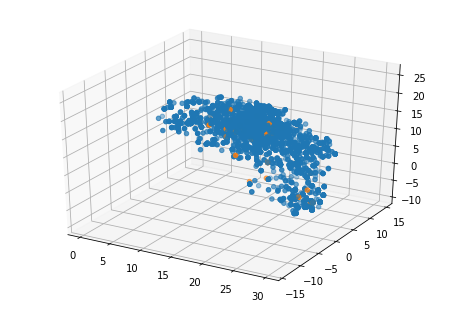

(3423,)


In [22]:
colors = []
for l in batch_labels_np:
    colors.append("C"+str(int(l)))
    
#plt.scatter(x_encoded,y_encoded,c=colors)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x_encoded,y_encoded,z_encoded,c=colors)
plt.show()
#plt.show()

print(x_encoded.shape)

In [23]:
def sample_z(size):
    ind = torch.cuda.LongTensor(torch.randperm(no_examples)[:size].numpy())
    return z_encoded[ind], batch_labels[ind]

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.l1 = nn.Linear(z_dim,400)
        self.l2 = nn.Linear(400,400)
        self.l3 = nn.Linear(400,70)
        self.l4 = nn.Linear(70,1)
        
    def forward(self,x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.sigmoid(self.l4(x))
        
        return x

In [25]:
def train_disc(d,d_optim):
    for ep in range(2000):
        d_optim.zero_grad()
        x,true_l = sample_z(50)
        p_labels = d(x)
        criteria = nn.BCELoss()
        loss = criteria(p_labels,true_l)
        loss.backward(retain_variables = True)
        d_optim.step()
        
        if(ep%50==49):
            print(loss.data[0])
            
    return d
    

In [26]:
def gen_disc_model():
    d = Discriminator()
    d.cuda()
    d_optim = optim.Adam(d.parameters(),lr=1e-4)
    d = train_disc(d,d_optim)
    return d

In [27]:
d = gen_disc_model()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Check on Training Data 

In [ ]:
entire_batch,batch_labels = get_train_batch(no_examples)
train_encoded = Q(entire_batch)
train_op = d(train_encoded)

In [ ]:
print(train_op.cpu().data.numpy())

In [ ]:
train_op = train_op.cpu().data.numpy()
train_op[train_op>0.5] = 1
train_op[train_op<0.5] = 0
print(sum(train_op))